In [1]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import dendropy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

import json
import baltic as bt
from scipy.stats import linregress
import numpy as np
import pandas as pd
from itertools import combinations
import pickle
from copy import deepcopy

In [2]:
out_path = './png/'
colors = pickle.load(open('./colors.p', 'r'))

tree_file = '../data/augur-output/dengue_allBranchEffects_tree.json'
titer_tree = bt.loadJSON(tree_file, {'name': 'clade', 'height': 'cTiter'})
uncollapsed_tree = deepcopy(titer_tree)

genotype_tree = bt.loadNexus('../frequencies/source/annotated_tree.nexus', absoluteTime=False)
genotype_lookup = { k.traits['clade'] : k.traits['genotype'] for k in genotype_tree.Objects if 'genotype' in k.traits }
serotype_lookup = { k.traits['clade'] : k.traits['serotype'] for k in genotype_tree.Objects if 'serotype' in k.traits }


Tree height: 1.955144
Tree length: 6.071398
annotations present

Numbers of objects in tree: 4792 (2230 nodes and 2562 leaves)



In [11]:
def antigenically_uniform(node, tree):
    descendants = [k for k in tree.traverse_tree(node, include_all=True)]
    trait_values = [round(k.traits['cTiter'], 2) for k in descendants]
    if len(set(trait_values)) > 1:
        return False
    else:
        return True
      
def adjust_width(child, parent):
    if 'width' in child.traits:
        w = child.traits['width']
    else:
        w = 1
    if 'width' in parent.traits:
        parent.traits['width'] += w
    else:
        parent.traits['width'] = w
        
def reattach(k, tree):
    parent = k.parent
    k.parent.children.remove(k)
    
    if k.branchType=='node':
        children = k.children
        for child in children:
            child.parent = parent
            parent.children.append(child)
            adjust_width(child, parent)

    else:
        adjust_width(k, parent)

## Get the easy antigenically-uniform clades first
uniform_nodes = [k for k in sorted(titer_tree.Objects, key=lambda k: k.height) if antigenically_uniform(k, titer_tree)]
uniform_mrcas = [k for k in uniform_nodes if k.parent not in uniform_nodes and k.branchType=='node']

for k in sorted(uniform_mrcas, key = lambda k: k.height):
    titer_tree.collapseSubtree(k, k.traits['clade'])
    
for k in titer_tree.Objects:
    if hasattr(k, 'width'):
        k.traits['width'] = k.width
        k.width = 1

## Go back to clean up remaining polytomies
to_remove = []

for k in sorted(titer_tree.Objects, key=lambda k:-1*k.height):
    if k.traits['dTiter'] < 0.01:
        reattach(k, titer_tree)
        to_remove.append(k)

for k in to_remove:
    titer_tree.Objects.remove(k)

titer_tree.drawUnrooted()

In [12]:
def plot_tree(ll, ax, cax, cmap=colors['cmap']):
    sns.set(style='white')

#     max_width = max([k.traits['width'] for k in ll.Objects if isinstance(k, bt.clade)])
    branchWidth = 3

    for k in ll.Objects: # Plot objects
        x=k.x 
        y=k.y 

        xp=k.parent.x 
        yp=k.parent.y
        if x==None:
            x=0.0
        if xp==None:
            xp=x

        ## Color
        clade = k.traits['clade']
        if clade in genotype_lookup and 'SYLVATIC' not in genotype_lookup[clade]:
            genotype = genotype_lookup[clade]
            label=genotype.replace('_', ' ')
            c = colors[genotype]
        elif clade in serotype_lookup:
            serotype = serotype_lookup[clade]
            label=serotype
            c = colors[serotype]
        else:
            c = 'darkgray'
            label=''

#         if k.branchType=='leaf': ### Plot tips and clades
        if isinstance(k, bt.clade):
            s = k.traits['width']
        else:
            s = 20

        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s*2,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        ax.plot([xp,x],[yp,y],lw=branchWidth,color=c,ls='-',zorder=9)
        ax.text(x+0.05, y, label, ha='left', va='center')

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.tick_params(axis='x',size=0) ## no labels
    ax.tick_params(axis='y',size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

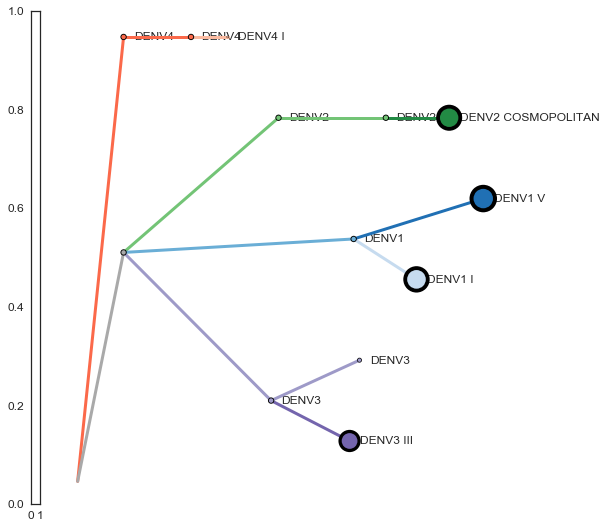

13
13


In [37]:
sns.set(style='white', font_scale=1.2)
fig, (cax, ax) = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 7.5), gridspec_kw={'width_ratios': (0.02, 1.)}) # quarter page

titer_tree.drawTree()
plot_tree(titer_tree, ax=ax, cax=cax)#, cmap=cmap)

plt.tight_layout()
# plt.savefig('./png/antigenic_tree.png', dpi=300, bbox_inches='tight')
plt.show()

print len([k for k in uncollapsed_tree.Objects if k.traits['dTiter'] > 0.01])
print len(titer_tree.Objects)

In [38]:
# def plot_radial_tree(tree, ax, cax, cmap=colors['cmap']):
    
#     ## Color bar and formatting
#     sns.set(style='white', font_scale=1.2)
# #     max_c = max([k.traits[colorby] for k in tree.Objects if colorby in k.traits ])
    
# #     norm = mpl.colors.Normalize(vmin=0, vmax=max_c)
# #     cb = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, orientation='vertical', 
# #                                    norm=norm, label="Cumulative log2(titer) distance from root")    
# #     cax.yaxis.set_label_position('left')
# #     cax.yaxis.set_ticks_position('left')
# #     cb.set_label("Cumulative log2(titer) distance from root", )

#     ## Setup params
#     branchWidth=3 
#     inwardSpace=-1.15 # < -1 points outwards; > 1 points inwards
#     gap=0.6 # determines how much of their allocated space along the circle a tree uses
#     startFrom=np.pi ## start at some point along the circle

#     ## Bounds
#     leaves = [k for k in tree.Objects if k.branchType=='leaf']
#     leafCount = len(leaves)
#     mostRecent = max([float(k.traits['cTiter']) for k in leaves])
#     max_width = max([k.traits['width'] for k in tree.Objects if isinstance(k, bt.clade)])

#     ## Plot Objects
#     for k in tree.Objects: 
#         ### Coordinates
#         y=k.y 
#         x=k.x 
#         xp=k.parent.x 

#         if x==None: 
#             x=0.0
#         if xp==None:
#             xp=x

#         ### Convert to polar
#         xc=inwardSpace+((mostRecent-x)/tree.treeHeight) ## transform x coordinate
#         xpc=inwardSpace+((mostRecent-xp)/tree.treeHeight) ## transform x parent's coordinate
#         yc=2*np.pi*(y/float(leafCount))*gap ## transform y coordinate

#         ### Color
#         clade = k.traits['clade']
#         if clade in genotype_lookup and 'SYLVATIC' not in genotype_lookup[clade]:
#             genotype = genotype_lookup[clade]
#             c = colors[genotype]
#         elif clade in serotype_lookup:
#             serotype = serotype_lookup[clade]
#             c = colors[serotype]
#         else:
#             c = 'darkgray'

#         if k.branchType=='leaf': ### Plot tips and clades
#             if isinstance(k, bt.clade):
#                 s = k.traits['width']
#             else:
#                 s = 20
#             ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s,facecolor=c,edgecolor='none',zorder=50) ## plot circle for every tip
#             ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=40) ## plot black circle underneath

#         elif isinstance(k,bt.node): ### Plot nodes
#             yl=k.children[-1].y 
#             yr=k.children[0].y 
#             ycl=2*np.pi*(yl/float(leafCount))*gap 
#             ycr=2*np.pi*(yr/float(leafCount))*gap 
#             ybar=np.linspace(ycl,ycr,15) ## create a curved bar
#             ax.plot(np.sin(ybar)*xc,np.cos(ybar)*xc,lw=branchWidth,color=c,ls='-',zorder=30) ## plot curved bar at the base of a node

#         ### Plot ancestralbranch
#         ax.plot([np.sin(yc)*xc,np.sin(yc)*xpc],[np.cos(yc)*xc,np.cos(yc)*xpc],lw=branchWidth,color=c,ls='-',zorder=30)

                     
#     ## Final axis formatting
#     ax.spines['top'].set_visible(False) 
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)

#     ax.tick_params(axis='x',size=0) 
#     ax.tick_params(axis='y',size=0)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

#     ax.set_aspect(1) 
#     x0,x1 = plt.xlim()
#     plt.xlim((x0-0.1, x1+0.1))
#     y0,y1 = plt.ylim()
#     plt.ylim((y0-0.2,y1+0.3))

# titer_tree.drawTree()
# sns.set(style='white', font_scale=1.2)
# fig, (cax, ax) = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 7.5), gridspec_kw={'width_ratios': (0.02, 1.)}) # quarter page

# plot_tree(titer_tree, ax=ax, cax=cax)

# circles = [patches.Circle((0,0), radius=n, axes=ax, ec='lightgray', fc='none', ls='--', lw=1) for n in [0.25, 0.75, 1.25]]
# circles += [patches.Circle((0,0), radius=n, axes=ax, ec='darkgray', fc='none', ls='--', lw=1) for n in [0.5, 1.]]

# for circ in circles:
#     ax.add_patch(circ)

# plt.tight_layout()
# # plt.savefig('./png/antigenic_tree.png', dpi=300, bbox_inches='tight')
# plt.show()